In [1]:
from figures import *

import matplotlib.ticker as mticker

def getbestcolonies(colonylist, adata, vdata, abar=0.05):
    # Get out the best performing colonies.
    colonybest = []
    for n in colonylist:
        alist = adata[n]
        vlist = vdata[n]

        if np.mean( alist[vlist] ) < abar:
            colonybest += [n]
    return colonybest
    # args = num, N, tau, dtexp, dtsim, (alist, apeak, avarn), (peak, vall, vmaxd, vmean)

In [2]:
# Import and unpack colony-level data.
colony = 'EGTi'
colonyfilelist, (colonylist, Nlist), (dtexp, tlist, adata) = importcolonydata( colony )
Nuniq = np.unique( Nlist )

# Colonies to remove based on frequency analysis.
# colonybad = [26, 31, 11]
colonybad = [3, 12, 15, 16, 23, 24, 28]
colonygood = np.setdiff1d( colonylist, colonybad, assume_unique=True )

# Extract valley data.
vdata = [find_peaks( -alist, prominence=1/4*(np.max( alist ) - np.min( alist )) )[0]
    for alist in adata]

# Compute metrics over the colonies.
metriclist = (dominantperiod, activity, peakheight, valleydepth)
mdata = np.array( [metric( adata ) for metric in metriclist] ).T

# Compile hyper metrics list.
hyper = (colonygood, Nlist, adata, vdata, mdata)

# Offset position of interest and delay (fixed).
Nc = 10

In [3]:
def rsquared(y, f):
    ss_res = np.sum( (y - f)**2 )
    ss_tot = np.sum( (y - np.mean(y))**2 )
    return 1 - ss_res / ss_tot

def adjrsquared(y, f):
    R2 = rsquared( y, f )
    return 1/(1 - R2)

def adjvariance(y, f):
    sig = np.std( np.abs( y - f ) )
    return 1/sig

wfixd = [0,1,1,1/25]
def fixedweights(i):
    return wfixd[i]

# Fit extraction using active valley threshold.
def extractfit(abar, hyper, verbose=False):
    # Unpack hyper parameters.
    colonylist, Nlist, adata, vdata, mdata = hyper

    # Extract the best colonies.
    colonybest = getbestcolonies( colonylist, adata, vdata, abar=abar )

    # Fit scaling laws.
    Nbest = Nlist[colonybest]
    mbest = mdata[colonybest]
    fitlist = [fitscalinglaw( Nbest, Nbest*mlist if i > 0 else mlist ) for i, mlist in enumerate( mbest.T )]

    # Extract fit coefficients and coeff. of determination.
    plist = np.array( [fit.params for fit in fitlist] )
    wlist = np.array( [
        fixedweights( i )
        # adjvariance( Nbest*mlist if i > 0 else mlist, np.exp( eps )*Nbest**phi )
        for i, ((eps, phi), mlist) in enumerate( zip( plist, mbest.T ) )] )

    # Return fit and gains.
    if verbose:
        return (plist, wlist), fitlist
    return plist, wlist

# Comile argument list.
def createarguments(plist, Rlist, tau):
    olist = np.array( [np.exp( p[0] )*Nc**p[1] for p in plist] )
    return (Nuniq, tau, plist[1:], Rlist[1:], (Nc, olist[1:]))

def cost(logtheta, args, verbose=False, perd=False):
    # Unpack calibration arguments.
    Nlist, tau, plist, wlist, (Nc, olist) = args
    epslist = [p[0] for p in plist]
    philist = [p[1] for p in plist]

    # Generate list of parameters.
    theta = np.exp( logtheta )
    if np.linalg.norm( theta[1] ) < 1e-12:
        print( 'WARNING: gamm was pushed to zero.' )
        return np.inf

    # Compute metrics for each of the virtual colonies.
    paramslist = [createparams( N, theta, tau ) for N in Nlist]
    mdata = np.array( Parallel( n_jobs=-1 )(
        delayed( computemetrics )( params, T=100*tau, dt=1/20, computeperd=perd )
        for params in paramslist ), dtype=float ).T

    # Compute model scaling.
    fitmodl = [fitscalinglaw( Nlist, Nlist*mlist ) for mlist in mdata[1:]]

    # Extract model scaling parameters.
    epsmodl = np.array( [fit.params[0] for fit in fitmodl] )
    phimodl = np.array( [fit.params[1] for fit in fitmodl] )
    omodl = [np.exp( fit.params[0] )*Nc**fit.params[1] for fit in fitmodl]

    print( wlist, philist, '|', theta, phimodl )
    C = np.sum( wlist*(phimodl - philist)**2 ) #+ 1/100*np.sum( wlist*(omodl - olist)**2 )

    if verbose:
        return C, (fitmodl, mdata)
    return C

def calibratedmetrics(params, T=None, cut=None, dt=1e-2, computeperd=True):
    # Default simulation time.
    T = 100*params['tau'] if T is None else T
    cut = round( 10*params['tau']/dt ) if cut is None else cut

    # Simulate model with parameter choice and extract activity.
    tlist, xlist = simulate( params, T, [1/2,1/2,0], dt=dt )
    alist = xlist.T[0]

    # Compute and return metrics.
    aperd = cycleperiod( alist, cut, dt=dt ) if computeperd else None
    adiff = peakvalleydiff( alist, cut )
    return aperd, adiffs

In [4]:
trial = 10;  runcalibration = 1
if runcalibration:
    # Initial guess.
    logtheta0 = np.log( [0.1, 0.01] )

    # List of thresholds.
    taumin = 50;  taumax = 100
    taulist = np.arange( taumin, taumax+1, 5 )

    # Run optimization problem.
    resultslist = [minimize( cost, logtheta0,
        args=(createarguments( *extractfit( 1, hyper ), tau ),), method='Nelder-Mead' )
        for tau in taulist]
    thetalist = np.array( [np.exp( results.x ) for results in resultslist] )
else:
    filename = '../data/results/exponent-calibration/varyingtau-%i_Nc-%i' % (trial, Nc)
    taulist, betalist, gammlist = loaddata( filename )
    thetalist = np.vstack( (betalist, gammlist) ).T
print( thetalist )

[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.1  0.01] [1.043 0.891 1.296]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.089 0.01 ] [1.032 0.962 1.119]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.1   0.008] [1.05  0.875 1.323]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.112 0.008] [1.056 0.777 1.586]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.106 0.008] [1.048 0.829 1.435]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.106 0.011] [1.041 0.857 1.391]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.109 0.012] [1.045 0.853 1.424]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.112 0.009] [1.055 0.79  1.564]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.103 0.01 ] [1.04

In [5]:
fcostlist = [cost( np.log( theta ), createarguments( *extractfit( 1, hyper ), tau ), verbose=True, perd=True )
    for tau, theta in zip( taulist, thetalist )]

costlist = [fcost[0] for fcost in fcostlist]
calblist = [fcost[1][0] for fcost in fcostlist]
modllist = [fcost[1][1] for fcost in fcostlist]

phatlist = np.array( [[phi.params[1] for phi in calb] for calb in calblist] )

[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.107 0.01 ] [1.043 0.844 1.417]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.097 0.009] [1.043 0.844 1.415]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.089 0.008] [1.043 0.845 1.413]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.088 0.014] [1.024 0.892 1.415]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.082 0.013] [1.024 0.891 1.416]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.076 0.012] [1.024 0.891 1.416]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.071 0.011] [1.024 0.89  1.416]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.067 0.01 ] [1.024 0.89  1.416]
[1.   1.   0.04] [0.6294295756861528, 0.7101779236545127, 0.602879891786262] | [0.063 0.01 ] [1.

In [6]:
Nrange = np.linspace( 10,500,20 )

# Select colony for plotting.
itau = -1
mtemp = modllist[itau]
thetatemp = thetalist[itau]
calbtemp = calblist[itau]
(ptemp, wtemp), fittemp = extractfit( taulist[itau], hyper, verbose=True )

# Compute change in the nonlinear model.
paramstemp = [createparams( N, thetatemp, taulist[itau] ) for N in Nrange]

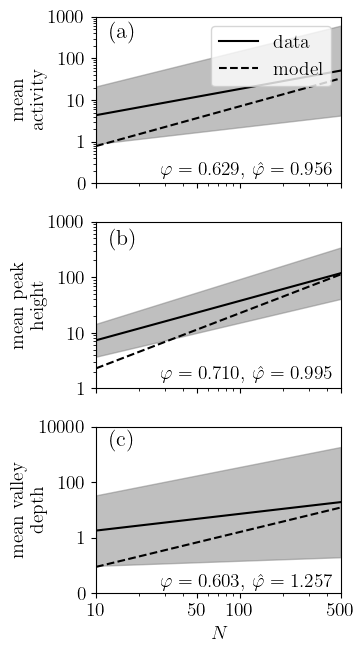

In [7]:
showpoints = 0

plotmetrics = [1,2,3]
markerlist = ('(a)', '(b)', '(c)', '(d)', '(e)')
metriclabel = (
    'oscillation\nperiod',
    'mean\nactivity',
    'mean peak\nheight',
    'mean valley\ndepth',
    )

# Plot scaling fit against the original data.
fig, axs = plt.subplots( len( plotmetrics ),1,sharex=True )
axs = axs if len( plotmetrics ) > 1 else [axs]
for i, a in enumerate( axs ):
    imetric = plotmetrics[i]

    # Extract scaling law.
    eps, phi = fittemp[imetric].params
    a.plot( Nrange, np.exp( eps )*Nrange**phi,
        color='k', label='data' )

    # Plot model scaling.
    epsmodl, phimodl = fitscalinglaw( Nuniq, Nuniq*mtemp[imetric] if imetric > 0 else mtemp[imetric] ).params
    a.plot( Nrange, np.exp( epsmodl )*Nrange**phimodl, color='k', linestyle='--', label='model' )

    if showpoints:
        Ngood = Nlist[colonygood]
        a.scatter( Ngood, Ngood*mdata[colonygood].T[imetric] if imetric > 0 else mdata[colonygood].T[imetric], color='gray' )

    # Extract confidence intervals.
    epsdn, epsup = fittemp[imetric].conf_int()[0]
    phidn, phiup = fittemp[imetric].conf_int()[1]

    ycidn = np.exp( epsdn )*Nrange**phidn
    yciup = np.exp( epsup )*Nrange**phiup
    a.fill_between( Nrange, ycidn, yciup, color='gray', alpha=1/2 )

    # Extract bounds of the figure.
    ymin = np.floor( np.log10( np.min( ycidn ) ) )
    ymax = np.ceil(  np.log10( np.max( yciup ) ) )

    a.text( 0.90*Nrange[-1], 1.25*10**ymin,
        '$\\varphi=%.3f$, $\\hat \\varphi=%.3f$' % (phi, phimodl), va='bottom', ha='right' )
    a.text( 1.25*Nrange[0], 0.75*10**ymax, markerlist[i], fontsize=16, va='top', ha='left' )

    a.set_ylim( [10**ymin, 10**ymax] )

    a.set_xscale( 'log' )
    a.set_yscale( 'log' )


axs[-1].set_xlim( [Nrange[0], Nrange[-1]] )

for i, a in enumerate( axs ):
    a.set_ylabel( metriclabel[plotmetrics[i]] )
    a.xaxis.set_major_formatter( mticker.ScalarFormatter() )
    a.yaxis.set_major_formatter( mticker.ScalarFormatter() )
    a.yaxis.set_label_coords( -0.25, 0.5 )
axs[-1].set_xlabel( '$N$' )
axs[0].legend( loc=1 )


xticks = [10, 50, 100, 500]
axs[-1].set_xticks( xticks, xticks )

for a in axs:
    a.yaxis.set_label_coords( -0.20, 0.5 )

fig.set_figwidth( 4 )
fig.set_figheight( 2.25*len( axs ) )
fig.tight_layout()

if 0:
    savefigure( fig, 'results/calibrated_scaling' )

In [8]:
def calibratedmetrics(params, T=None, cut=None, dt=1e-2, computeperd=True):
    # Default simulation time.
    T = 100*params['tau'] if T is None else T
    cut = round( 10*params['tau']/dt ) if cut is None else cut

    # Simulate model with parameter choice and extract activity.
    tlist, xlist = simulate( params, T, [1/2,1/2,0], dt=dt )
    alist = xlist.T[0]

    # Compute and return metrics.
    aperd = cycleperiod( alist, cut, dt=dt ) if computeperd else None
    adiff = peakvalleydiff( alist, cut )
    return aperd, adiff

In [9]:
# Unpack results.
theta = thetalist[-1]
tau = taulist[-1]
paramslist = [createparams( N, theta, tau ) for N in Nuniq]

# Extract metric information.
Ngood = Nlist[colonygood]
bdata = np.array( Parallel( n_jobs=-1 )( delayed( metric )( adata[colonygood] )
    for metric in (dominantperiod, peakvalleydifference)) )
bmodl = np.array( Parallel( n_jobs=-1 )( delayed( calibratedmetrics )( params )
    for params in paramslist ) ).T

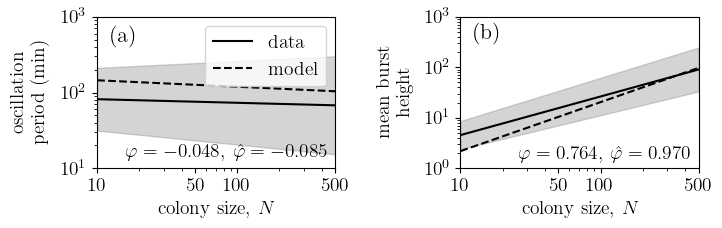

In [10]:
# Select metrics for plotting.
metriclabel = (
    'oscillation\nperiod (min)',
    'mean burst\nheight', )

# Plot scaling fit against the original data.
fig, axs = plt.subplots( 1,2,sharex=True )
axs = axs if len( plotmetrics ) > 1 else [axs]
for i, a in enumerate( axs ):
    # Unpack metric lists.
    blist = Ngood*bdata[i] if i > 0 else bdata[i]
    btemp = Nuniq*bmodl[i] if i > 0 else bmodl[i]

    # Extract exponent from metric data.
    fit = fitscalinglaw( Ngood, blist )
    eps, phi = fit.params
    epsdn, epsup = fit.conf_int()[0]
    phidn, phiup = fit.conf_int()[1]

    # Plot scaling law.
    a.plot( Nrange, np.exp( eps )*Nrange**phi, color='k', label='data' )

    # Plot model scaling.
    fithat = fitscalinglaw( Nuniq, btemp )
    epshat, phihat = fithat.params

    # Plot model scaling.
    a.plot( Nrange, np.exp( epshat )*Nrange**phihat, color='k', linestyle='--', label='model' )

    ycidn = np.exp( epsdn )*Nrange**phidn
    yciup = np.exp( epsup )*Nrange**phiup
    a.fill_between( Nrange, ycidn, yciup, color='gray', alpha=1/3 )

    # Extract bounds of the figure.
    ymin = np.floor( np.log10( np.min( ycidn ) ) )
    ymax = np.ceil(  np.log10( np.max( yciup ) ) )

    a.text( 0.90*Nrange[-1], 1.25*10**ymin,
        '$\\varphi=%.3f$, $\\hat \\varphi=%.3f$' % (phi, phihat), va='bottom', ha='right' )
    a.text( 1.25*Nrange[0], 0.75*10**ymax, markerlist[i], fontsize=16, va='top', ha='left' )

    a.set_ylim( [10**ymin, 10**ymax] )


axs[-1].set_xlim( [Nrange[0], Nrange[-1]] )

for i, a in enumerate( axs ):
    a.set_ylabel( metriclabel[i] )

    a.xaxis.set_major_formatter( mticker.ScalarFormatter() )
    a.yaxis.set_major_formatter( mticker.ScalarFormatter() )
    a.yaxis.set_label_coords( -0.25, 0.5 )

    a.set_xscale( 'log' )
    a.set_yscale( 'log' )

axs[0].legend( loc=1 )

xticks = [10, 50, 100, 500]
axs[-1].set_xticks( xticks, xticks )

for a in axs:
    a.set_xlabel( 'colony size, $N$' )
    a.yaxis.set_label_coords( -0.20, 0.5 )

fig.set_figwidth( 7.5 )
fig.set_figheight( 2.5 )
fig.tight_layout()

if 0:
    savefigure( fig, 'results/scaling_calibration' )

In [11]:
# Compute the scaling exponent for each solution of the calibration.
bmodldata = np.array( [Parallel( n_jobs=-1 )(
    delayed( calibratedmetrics )( createparams( N, theta, tau ) )
    for N in Nuniq ) for theta in thetalist] ).T

In [12]:
fitdata = [[fitscalinglaw( Nuniq, Nuniq*bmodl if i > 0 else bmodl ) for bmodl in bmodllist.T]
    for i, bmodllist in enumerate( bmodldata )]
phatdata = np.array( [[fit.params[1] for fit in fitlist] for fitlist in fitdata] )

In [13]:
print( phatdata )

[[-0.088 -0.088 -0.088 -0.089 -0.089 -0.089 -0.088 -0.088 -0.087 -0.088 -0.085]
 [ 0.949  0.907  0.865  0.89   0.865  0.841  0.818  0.797  0.778  0.916  0.97 ]]


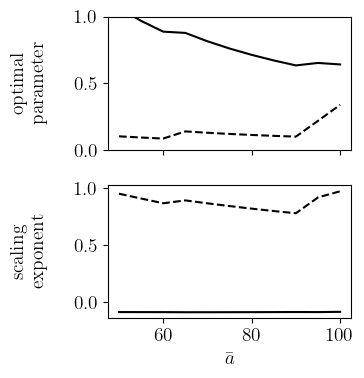

In [21]:
# Plot optimal social parameters as a function of the delay.
fig, axs = plt.subplots( 2,1,sharex=True )

axs[0].plot( taulist, 10*thetalist.T[0], color='k', label='$\\beta^*$' )
axs[0].plot( taulist, 10*thetalist.T[1], color='k', linestyle='--', label='$\\gamma^*$' )

# axs[0].text( 0.395, 0.925, '(a)', va='top', ha='right' )

# axs[0].set_xlim( [taumin, taumax] )
# axs[0].set_xticks( [k*0.1 for k in range( 1,5 )] )
axs[0].set_ylim( [0,1] )

axs[0].set_ylabel( 'optimal\nparameter' )

axs[1].plot( taulist, phatdata[0], color='k', label='oscillation period' )
axs[1].plot( taulist, phatdata[1], color='k', linestyle='--', label='burst height' )

# axs[1].text( 0.395, 0.725, '(b)', va='top', ha='right' )

# axs[1].set_ylim( [-0.2,0.8] )
# axs[1].set_yticks( [-0.2, 0.3, 0.8] )

axs[1].set_xlabel( '$\\bar a$' )
axs[1].set_ylabel( 'scaling\nexponent' )

for a in axs:
    a.yaxis.set_label_coords( -0.25, 0.5 )
    # a.legend( loc=6 )

fig.set_figwidth( 4 )
fig.set_figheight( 2*len( axs ) )
fig.tight_layout()

if 0:
    savefigure( fig, 'methods/calibration_sensitivity' )

In [15]:
if runcalibration:
    savedata( '../data/results/exponent-calibration/varyingtau-%i_Nc-%i' % (trial, Nc), \
        np.vstack( (taulist, thetalist.T) ) )